In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tensorflow opencv-python
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


In [7]:
dataset_path = '/content/drive/MyDrive/GRP 10 EDI DATASET'  # Change if your path is different
IMG_SIZE = 224
BATCH_SIZE = 32


In [8]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print("Classes:", train_generator.class_indices)


Found 2989 images belonging to 3 classes.
Found 746 images belonging to 3 classes.
Classes: {'Diabetic Retinopathy': 0, 'Glaucoma': 1, 'Normal': 2}


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1547s 16s/step - accuracy: 0.4626 - loss: 1.1260 - val_accuracy: 0.7332 - val_loss: 0.6751
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 567s 6s/step - accuracy: 0.7261 - loss: 0.7105 - val_accuracy: 0.8231 - val_loss: 0.5501
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 531s 6s/step - accuracy: 0.7781 - loss: 0.5946 - val_accuracy: 0.8432 - val_loss: 0.4816
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - accuracy: 0.8070 - loss: 0.5538 - val_accuracy: 0.8525 - val_loss: 0.4390
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 537s 6s/step - accuracy: 0.8327 - loss: 0.4951 - val_accuracy: 0.8619 - val_loss: 0.4065
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 530s 6s/step - accuracy: 0.8312 - loss: 0.4682 - val_accuracy: 0.8646 - val_loss: 0.3865
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 533s 6s/step - accuracy: 0.8299 - loss: 0.4449 - val_accuracy: 0.8727 - val_loss: 0.3722
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.8449 - loss: 0.4406 - val_accuracy: 0.8740 -

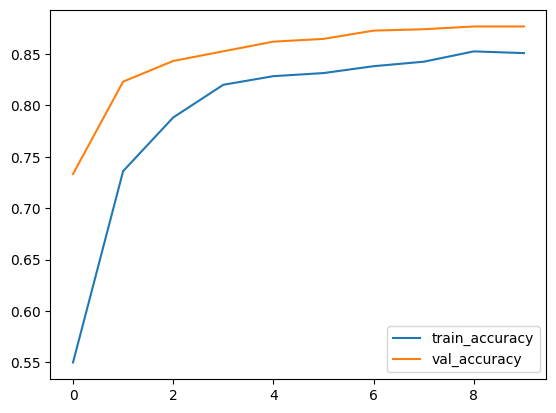

In [11]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


In [12]:
model.save('retina_model.h5')


In [13]:
from google.colab import files
files.download('retina_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

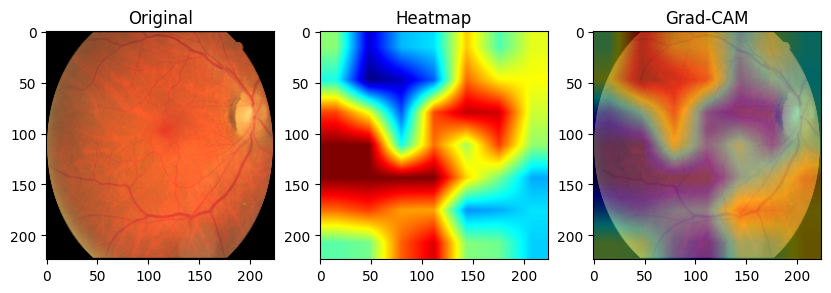

array([[[ 55, 102,  47],
        [ 55, 102,  47],
        [ 55, 102,  47],
        ...,
        [ 92, 102,  10],
        [ 92, 102,  10],
        [ 92, 102,  10]],

       [[ 55, 102,  47],
        [ 55, 102,  47],
        [ 55, 102,  47],
        ...,
        [ 92, 102,  10],
        [ 92, 102,  10],
        [ 92, 102,  10]],

       [[ 55, 102,  47],
        [ 55, 102,  47],
        [ 55, 102,  47],
        ...,
        [ 92, 102,  10],
        [ 92, 102,  10],
        [ 92, 102,  10]],

       ...,

       [[ 36, 102,  66],
        [ 36, 102,  66],
        [ 36, 102,  66],
        ...,
        [  0,  83, 102],
        [  0,  83, 102],
        [  0,  83, 102]],

       [[ 36, 102,  66],
        [ 36, 102,  66],
        [ 36, 102,  66],
        ...,
        [  0,  83, 102],
        [  0,  83, 102],
        [  0,  83, 102]],

       [[ 36, 102,  66],
        [ 36, 102,  66],
        [ 36, 102,  66],
        ...,
        [  0,  83, 102],
        [  0,  83, 102],
        [  0,  83, 102]]], dtype=uint8)
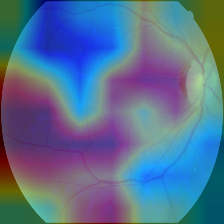

In [20]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

IMG_SIZE = 224  # Ensure this matches your model input size

def generate_gradcam(model, img_path, layer_name=None):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # If layer_name not provided, pick the last conv layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    # Get the gradient of the predicted class w.r.t. the last conv layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    # Multiply each channel by the importance
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Generate heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize to 0-1

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Heatmap")
    plt.imshow(heatmap)

    plt.subplot(1, 3, 3)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))

    plt.show()

    return superimposed_img
test_image_path = '/content/drive/MyDrive/GRP 10 EDI DATASET/Glaucoma/image_18.jpg'
generate_gradcam(model, test_image_path)


In [22]:
# Save trained model
model.save("/content/drive/MyDrive/retina_model.h5")
